In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from common import load_iris, percentile_rank, make_cdf

%matplotlib inline

# Correlation

Chapter 7 of [Think Stats 2nd Edition](https://greenteapress.com/wp/think-stats-2e/).

**Relationships between variables**
- linear and/or monotonic

In [2]:
iris = load_iris().features

The Iris dataset was used in R.A. Fisher's classic 1936 paper *The Use of Multiple Measurements in Taxonomic Problems*.

features.shape = (150, 4)
target.shape = (150, 3)


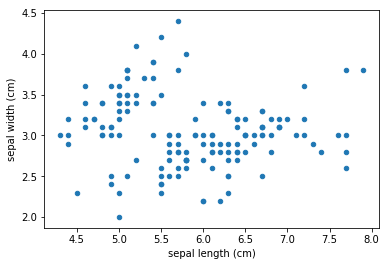

In [3]:
f, a = plt.subplots()

_ = iris.plot(kind='scatter', x='sepal length (cm)', y='sepal width (cm)', ax=a)

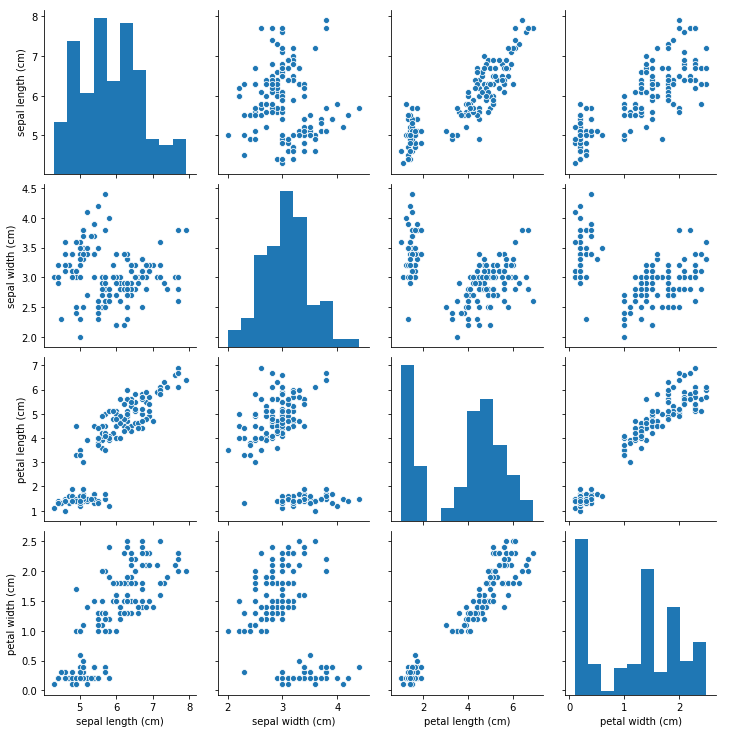

In [4]:
_ = sns.pairplot(iris)

Plotting percentiles against each other:

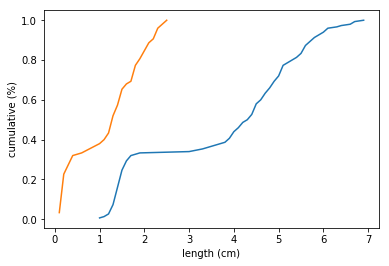

In [5]:
y, x = zip(*make_cdf(iris.loc[:, 'petal length (cm)']))
plt.plot(x, y)

y, x = zip(*make_cdf(iris.loc[:, 'petal width (cm)']))
plt.plot(x, y)

_ = plt.ylabel('cumulative (%)')
_ = plt.xlabel('length (cm)')

## Co-variance

Variance = how far a random variable is (on expectation) from its mean

$$ \sigma^2_X = \mathbf{E} [(X - {E}[X])^2] $$

Co-variance = measure of the **joint variability** of two random variables

$$ \sigma^2_{XY} = \mathbf{E} [(X-\mathbf{E}[X])(Y-\mathbf{E}[Y])] $$

Use delta degrees of freedom (`ddof`) of one for an unbiased estimate.

In [6]:
x = iris.loc[:, 'sepal length (cm)']
y = iris.loc[:, 'sepal width (cm)']

def covariance(x, y, ddof=1):
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / (x.shape[0] - ddof)

In [7]:
## co-variance with itself is the variance
np.testing.assert_almost_equal(covariance(x, x), np.var(x, ddof=1))
covariance(x, x)

0.6856935123042507

In [8]:
#  how does x change with y?
covariance(x, y)

-0.04243400447427292

The **co-variance matrix** shows all of the pairwise co-variances:

In [9]:
np.cov(x, y, ddof=1)

array([[ 0.68569351, -0.042434  ],
       [-0.042434  ,  0.18997942]])

What does an identity co-variance matrix imply?

In [10]:
np.eye(3) # uncorrelated unit variance components 

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Correlation

Correlation = **strength of a relationship** between two variables.  
- almost always it is a measure of the **linear relationship**
- correlation doesn't have to be perfect to be **useful**

Challenge = variables for different units

Solution = transform each value
1. a standard score (standardization)
2. a rank

## Karl Pearson 

1857 to 1936 - English biostatistician - [Wikipedia](https://en.wikipedia.org/wiki/Karl_Pearson).

![](assets/pearson.jpg)

Introduced
- Pearson correlation coefficient
- moments
- chi distance & chi squared test
- p-value
- PCA
- the histogram

## Pearson Correlation Coefficient

$$ \rho_{X,Y} = \frac{\mathbf{E}[(X - \mathbf{E}[X])(Y - \mathbf{E}[Y])]}{\sigma_{X}\sigma_{Y}} $$

- dimensionless
- always between -1 to +1
- measures a **linear relationship**
- assumes that both datasets are normally

Problem with co-variance = the units are the product (i.e. $cm^2$)
- Pearson's correlation fixes this by using standard scores (aka standardization)
- dividing by the standard deviation

$$ y = \frac{x-\mu}{\sigma} $$ 

In [11]:
from scipy.stats import pearsonr

def standardize(x):
    return (x - np.mean(x)) / np.std(x)

def pearson(x, y):
    return np.mean(standardize(x) * standardize(y))

pearson(x, y)

-0.11756978413300208

In [12]:
pearsonr(x, y)

(-0.11756978413300201, 0.15189826071144916)

## Spearman's Rank Correlation

Non-parametric (why?)

Dependence of the **ranks***
- assess strength & direction of monotonic relationships

Monotonic
- as one variable increases, so does the other variable; or
- as one variable increases, the other variable decreases

In [13]:
def rank(x):
    temp = x.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(x))
    return ranks

ranked = rank(x)

In [14]:
def spearman(x, y):
    x_ranks = rank(x)
    y_ranks = rank(y)
    return pearson(x_ranks, y_ranks)

spearman(x, y)

-0.19339703986843856

In [15]:
from scipy.stats import spearmanr, tiecorrect

corr, p_value = spearmanr(x, y)

corr

-0.166777658283235

why do we get different corr? can you find the bug? 

In [16]:
import scipy
pearson(scipy.stats.rankdata(x), scipy.stats.rankdata(y))

-0.166777658283235

In [18]:
#  using pandas here
iris.corr('spearman')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.166778,0.881898,0.834289
sepal width (cm),-0.166778,1.000000,-0.309635,-0.289032
petal length (cm),0.881898,-0.309635,1.000000,0.937667
petal width (cm),0.834289,-0.289032,0.937667,1.000000


## Anscombe's quartet 

[Wikipedia](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

Each dataset consists of eleven (x, y) points. 

Constructed in 1973 by the statistician Francis Anscombe to demonstrate:
- the importance of **graphing data before analyzing it**
- the **effect of outliers** and other influential observations on statistical properties

In [19]:
data = pd.DataFrame({
    'x': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
    'y1': [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    'y2': [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74],
    'y3': [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
})

data2 = pd.DataFrame({
    'x4': [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8],
    'y4': [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]
})

In [20]:
#  all our y's have similar means
data.mean(axis=0)

x     9.000000
y1    7.500909
y2    7.500909
y3    7.500000
dtype: float64

In [21]:
#  all our y's have similar variances
data.cov()

,x,y1,y2,y3
x,11.000,5.501000,5.500000,5.49700
y1,5.501,4.127269,3.095609,1.93343
y2,5.500,3.095609,4.127629,2.42524
y3,5.497,1.933430,2.425240,4.12262


In [22]:
#  x has different values - hence two dfs 
data2.cov()

,x4,y4
x4,11.000,5.499000
y4,5.499,4.123249


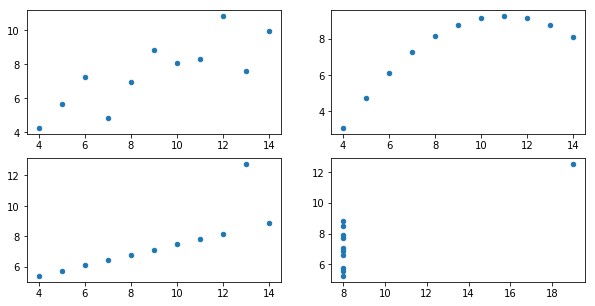

In [23]:
f, a = plt.subplots(2, 2, figsize=(10,5))
data.plot(ax=a[0][0], x='x', y='y1', kind='scatter')
data.plot(ax=a[0][1], x='x', y='y2', kind='scatter')
data.plot(ax=a[1][0], x='x', y='y3', kind='scatter')
data2.plot(ax=a[1][1], x='x4', y='y4', kind='scatter')

for ax in a.flatten():
    ax.get_yaxis().set_label_text('')
    ax.get_xaxis().set_label_text('')

a[0][0] = simple linear relationship

a[0][1] = Pearson correlation coefficient is not relevant. A more general regression and the corresponding coefficient of determination would be more appropriate.

a[1][0] = the distribution is linear, but should have a different regression line (a robust regression would have been called for). The calculated regression is offset by the one outlier which exerts enough influence to lower the correlation coefficient from 1 to 0.816.

a[1][1] =  one high-leverage point is enough to produce a high correlation coefficient, even though the other data points do not indicate any relationship between the variables.

## Quiz

What is variance?

What is covariance?

What is correlation?

What is challenge do the Pearson & Spearman correlations attempt to solve?

What is the Pearson correlation coefficient?  What kind of relationship does it measure?

What is the Spearman correlation coefficient?  What kind of relationship does it measure?

What are two takeaways from Anscombe's quartet?